Tässä notebookissa tehdään Silver-tason prosessoinnit datalle, eli ladataan bronze_pipeline.ipynb ETL-putken luomat lopputulokset ja otetaan data esikäsittellyyn. Esikäsittelyssä data putsataan ja prosessoidaan haluttuun muotoon. Tämän jälkeen data tallennetaan Gold-tason tauluun, joka toimii datan lopullisena tallennuspaikkana, josta sitä käytetään tämän projektin muissa välivaiheissa.

In [1]:
!pip install duckdb


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬──────────────────────────────────┬───────┬───────┬───────┬───────┐
│ node_id │            timestamp             │   x   │   y   │   z   │   q   │
│  int32  │             varchar              │ int32 │ int32 │ int32 │ int32 │
├─────────┼──────────────────────────────────┼───────┼───────┼───────┼───────┤
│   51992 │ 2019-03-06 15:34:02.078335+00:00 │     0 │     0 │     0 │    28 │
│   51992 │ 2019-03-06 15:34:03.078454+00:00 │     0 │     0 │     0 │    66 │
│   51992 │ 2019-03-07 11:40:37.07778+00:00  │     0 │     0 │     0 │   162 │
│   51992 │ 2019-03-07 12:31:06.078094+00:00 │     0 │     0 │     0 │    29 │
│   51992 │ 2019-03-07 13:04:55.079817+00:00 │     0 │     0 │     0 │   158 │
│   51992 │ 2019-03-07 13:05:04.079898+00:00 │     0 │     0 │     0 │   204 │
│   51992 │ 2019-03-07 13:05:05.080419+00:00 │     0 │     0 │     0 │   201 │
│   51992 │ 2019-03-07 13:05:08.080256+00:00 │     0 │     0 │     0 │    92 │
│   51992 │ 2019-03-07 13:05:14.080323+00:00 │     0

In [3]:
import duckdb
import pandas as pd
duckdb_path = "data/duckdb.database" # Duckdb tietokannalle annettava nimi, tallentuu lokaalisti
table_name = "Bronze_SensorData" # Tietokantataulu, josta luetaan

# Ota yhteys tietokantaa ja tarkista mitä dataa taulusta löytyy
conn = duckdb.connect(database=duckdb_path)
df = conn.sql(f"SELECT * FROM {table_name}").df() # Tallenentaan taulun data Pandasin dataframeen
conn.close()

In [4]:
df.info(verbose=True)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139961560 entries, 0 to 139961559
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
 4   z          int32 
 5   q          int32 
dtypes: int32(5), object(1)
memory usage: 3.6+ GB


,node_id,timestamp,x,y,z,q
0,51992,2019-03-06 15:34:02.078335+00:00,0,0,0,28
1,51992,2019-03-06 15:34:03.078454+00:00,0,0,0,66
2,51992,2019-03-07 11:40:37.07778+00:00,0,0,0,162
3,51992,2019-03-07 12:31:06.078094+00:00,0,0,0,29
4,51992,2019-03-07 13:04:55.079817+00:00,0,0,0,158
...,...,...,...,...,...,...
139961555,53795,2020-01-02 12:27:15.471987+00:00,-16,2572,0,42
139961556,53795,2020-01-02 12:29:19.471035+00:00,-66,2549,0,48
139961557,53795,2020-01-02 12:29:19.471038+00:00,-66,2549,0,48
139961558,53795,2020-01-02 12:37:30.47119+00:00,-71,2573,0,50


In [5]:
# Tehdään perus EDA (Explorative Data Analysis)
!pip install ydata-profiling
!pip install setuptools

python(364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


python(380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

#Tätä ei kannata ajaa koko datasetille, koska kestää ajallisesti tosi pitkään.
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("data_raportti.html")

/Users/heidipappila/code/projektiopinnot-1-datan-hallinta-ttm23sai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
python(98919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(98921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
# Tässä prosessoinnin vaiheessa poistetaan Z & Q sarakkeet

df = df.drop(columns=['z', 'q'])
print(df.describe())
df.info(verbose=True)

            node_id             x             y
count  1.399616e+08  1.399616e+08  1.399616e+08
mean   4.578467e+04  7.999079e+02  2.587674e+03
std    1.686354e+04  2.339921e+03  1.329330e+03
min    3.200000e+03 -3.281800e+04 -3.271800e+04
25%    5.175100e+04  4.100000e+01  2.440000e+03
50%    5.197600e+04  1.460000e+02  2.516000e+03
75%    5.253500e+04  7.580000e+02  2.642000e+03
max    6.445800e+04  3.271700e+04  3.281700e+04
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139961560 entries, 0 to 139961559
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   node_id    int32 
 1   timestamp  object
 2   x          int32 
 3   y          int32 
dtypes: int32(3), object(1)
memory usage: 2.6+ GB


In [7]:
# Tässä prosessoinnin vaiheessa laitetaan oikea tietotyyppi timestamp sarakkeelle (datetime)

df["timestamp"] = pd.to_datetime(df["timestamp"])

df.info(verbose=True)
print(df.head(n=10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139961560 entries, 0 to 139961559
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 2.6 GB
   node_id                        timestamp  x  y
0    51992 2019-03-06 15:34:02.078335+00:00  0  0
1    51992 2019-03-06 15:34:03.078454+00:00  0  0
2    51992 2019-03-07 11:40:37.077780+00:00  0  0
3    51992 2019-03-07 12:31:06.078094+00:00  0  0
4    51992 2019-03-07 13:04:55.079817+00:00  0  0
5    51992 2019-03-07 13:05:04.079898+00:00  0  0
6    51992 2019-03-07 13:05:05.080419+00:00  0  0
7    51992 2019-03-07 13:05:08.080256+00:00  0  0
8    51992 2019-03-07 13:05:14.080323+00:00  0  0
9    51992 2019-03-07 13:05:17.078480+00:00  0  0


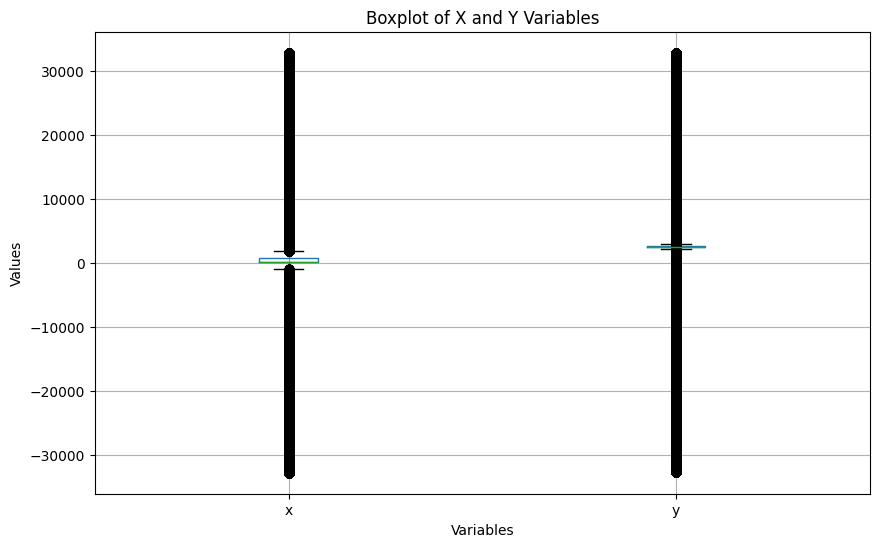

            node_id             x             y
count  1.399616e+08  1.399616e+08  1.399616e+08
mean   4.578467e+04  7.999079e+02  2.587674e+03
std    1.686354e+04  2.339921e+03  1.329330e+03
min    3.200000e+03 -3.281800e+04 -3.271800e+04
25%    5.175100e+04  4.100000e+01  2.440000e+03
50%    5.197600e+04  1.460000e+02  2.516000e+03
75%    5.253500e+04  7.580000e+02  2.642000e+03
max    6.445800e+04  3.271700e+04  3.281700e+04


In [8]:
# Tarkastellaan ja poistetaan Outlierit
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 23443604 entries, 0 to 139961559
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 626.0 MB


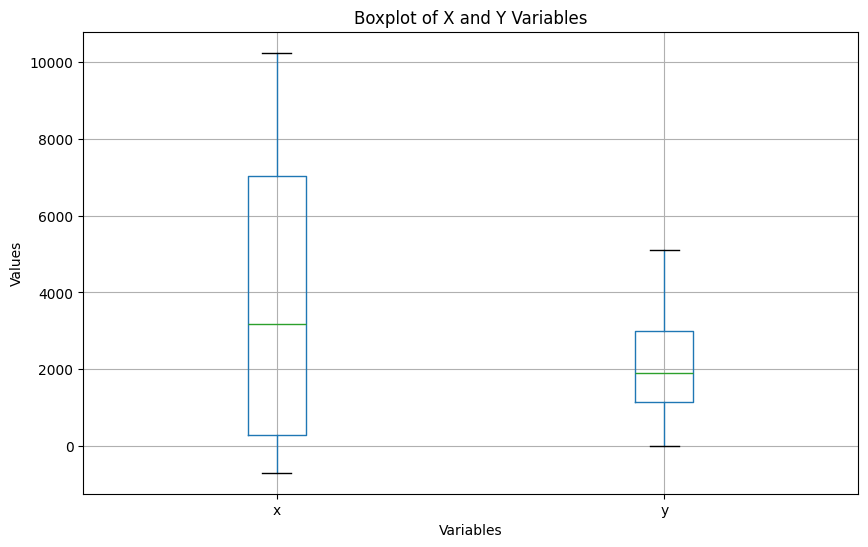

In [9]:
# Tarkastellaan ja poistetaan Outlierit

# Määritellään ylä ja alarajat X-akselissa 
lower_bound_X = -700
upper_bound_X = 10250


# Määritellään ylä ja alarajat y-akselissa
lower_bound_Y = 0
upper_bound_Y = 5100

# Filteröidään pois
outliers_X = df[(df['x'] < lower_bound_X) | (df['x'] > upper_bound_X)]
outliers_Y = df[(df['y'] < lower_bound_Y) | (df['y'] > upper_bound_Y)]

#Latausasemien filtteröinti
charging_station1 = df[df['x'].between(-150, 1600) & (df['y'] > 3000)]
charging_station2 = df[(df['y']> 2000) & df['x'].between(-150, 550)]


# Poistetaan outlierit
df = df[~df.index.isin(outliers_X.index) & ~df.index.isin(outliers_Y.index)]
df = df[~df.index.isin(charging_station1.index) & ~df.index.isin(charging_station2.index)]

df.info(verbose=True)





import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
df.boxplot(column=['x', 'y'])
plt.title('Boxplot of X and Y Variables')
plt.ylabel('Values')
plt.xlabel('Variables')
plt.show()

### Onko jotain muuta?

- Poistetaan järjestelmän koordinaatiston vanhat rajoitteet. Ainakin aikaisemmassa versiossa x,y akselit olivat rajoitettu tiettyyn arvoon, esim x>=(-50), jos kärryt menivät yli rajojen. Tällöin jos kärry meni alle -50 arvoon, niin se tallennettiin x=-50

In [10]:
limited_left_val = df['x'].isin([-50])
limited_upper_val = df['y'].isin([150])
limited_lower_val = df['y'].isin([5050])

print("Löydetty:", limited_lower_val.value_counts()[True], limited_left_val.value_counts()[True], limited_upper_val.value_counts()[True], "kpl")

df = df[~limited_left_val & ~limited_upper_val & ~limited_lower_val]

Löydetty: 290452 440330 136653 kpl


In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22685511 entries, 0 to 139961559
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   node_id    int32              
 1   timestamp  datetime64[ns, UTC]
 2   x          int32              
 3   y          int32              
dtypes: datetime64[ns, UTC](1), int32(3)
memory usage: 605.8 MB


In [12]:
from functions.database import create_db_table
from functions.database import insert_dataframe_into_table
from functions.database import drop_table

#from functions.database import drop_table
# Tallennetaan dataframe silver tauluun

table_name = "Silver_SensorData" # tai Silver_SensorData
duckdb_path = "data/duckdb.database"
schema = f'''
        CREATE TABLE {table_name} (
        node_id INTEGER NOT NULL,
        timestamp TIMESTAMP,
        x INTEGER NOT NULL,
        y INTEGER NOT NULL,
        )
        '''

drop_table(table_name, duckdb_path) # Poista kommentti, jos tarvitsee poistaa tietokantataulu
create_db_table(database=duckdb_path, table_name=table_name,schema=schema) # Luodaan tietokantataulu
insert_dataframe_into_table(database=duckdb_path, table_name=table_name, df=df, insert=True) # Lisätään dataframe tietokantatauluun (Insert, eli lisätään rivejä vanhan perään)



Table dropped
Silver_SensorData luotu
Tallennetaan dataframe tietokantaan, jonka muoto on: (22685511, 4)
Tallennus tauluun Silver_SensorData onnistui


In [13]:
# Tarkistetaan, miltä luotu taulu näyttää:
table_name = "Silver_SensorData"
duckdb_path = "data/duckdb.database"
import duckdb
conn = duckdb.connect(database=duckdb_path)
conn.table(table_name).show()
conn.close()

┌─────────┬────────────────────────────┬───────┬───────┐
│ node_id │         timestamp          │   x   │   y   │
│  int32  │         timestamp          │ int32 │ int32 │
├─────────┼────────────────────────────┼───────┼───────┤
│   51992 │ 2019-03-06 17:34:02.078335 │     0 │     0 │
│   51992 │ 2019-03-06 17:34:03.078454 │     0 │     0 │
│   51992 │ 2019-03-07 13:40:37.07778  │     0 │     0 │
│   51992 │ 2019-03-07 14:31:06.078094 │     0 │     0 │
│   51992 │ 2019-03-07 15:04:55.079817 │     0 │     0 │
│   51992 │ 2019-03-07 15:05:04.079898 │     0 │     0 │
│   51992 │ 2019-03-07 15:05:05.080419 │     0 │     0 │
│   51992 │ 2019-03-07 15:05:08.080256 │     0 │     0 │
│   51992 │ 2019-03-07 15:05:14.080323 │     0 │     0 │
│   51992 │ 2019-03-07 15:05:17.07848  │     0 │     0 │
│     ·   │             ·              │     · │     · │
│     ·   │             ·              │     · │     · │
│     ·   │             ·              │     · │     · │
│   51992 │ 2019-03-31 15:46:46